In [372]:
import os
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [373]:
project_root = Path.cwd().parent
db_path = project_root / "data" / "lichess.duckdb"
con = duckdb.connect(str(db_path))

In [374]:
binsize = 50
query = f"""
SELECT
    CAST(((white_elo + black_elo)/2 / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
    COUNT(*) AS total_games,
    SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) AS draws
FROM games_nobot
GROUP BY elo_bin
ORDER BY elo_bin

"""
df = con.execute(query).fetchdf()

In [375]:
rolling_bins = 10
min_games_per_bin = 200

df['draw_rate'] = df['draws'] / df['total_games']
# Smooth with rolling average
df['draw_rate_smooth'] = (
    (df['draw_rate'] * df['total_games'])
    .rolling(window=rolling_bins, center=True, min_periods=1)
    .sum() /
    df['total_games'].rolling(window=rolling_bins, center=True, min_periods=1).sum()
)

df_plot = df[df['total_games'] >= min_games_per_bin]

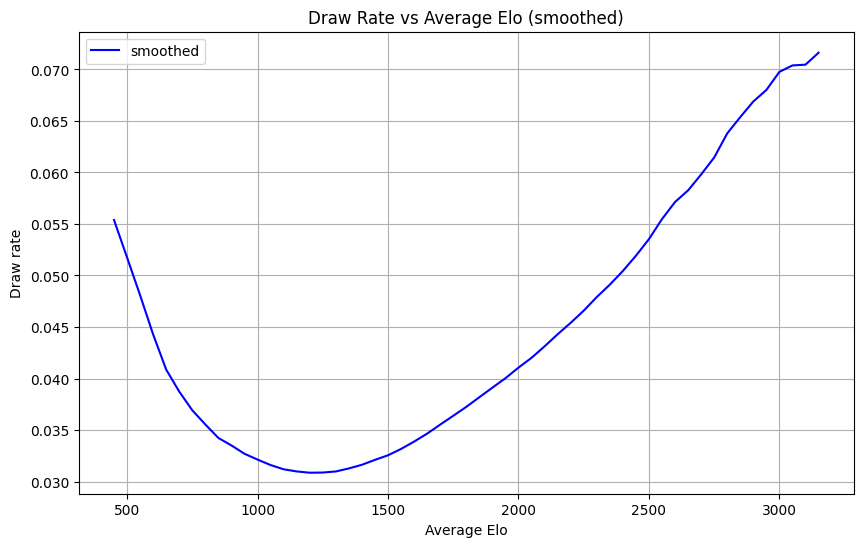

In [376]:
plt.figure(figsize=(10,6))
plt.plot(df_plot['elo_bin'], df_plot['draw_rate_smooth'], color='blue', label='smoothed')
plt.xlabel('Average Elo')
plt.ylabel('Draw rate')
plt.title('Draw Rate vs Average Elo (smoothed)')
plt.grid(True)
plt.legend()
plt.show()


In [377]:
time_controls = ("UltraBullet","Bullet","Blitz","Rapid","Classical", "Correspondence","Other")
tc_list_sql = ",".join([f"'{t}'" for t in time_controls])

In [378]:
query = f"""
WITH tc AS (
  SELECT
    CASE
      WHEN split_part(event, ' ', 1) IN ({tc_list_sql}) THEN split_part(event, ' ', 1)
      WHEN split_part(event, ' ', 2) IN ({tc_list_sql}) THEN split_part(event, ' ', 2)
      ELSE 'Other'
    END AS time_control,
    -- average Elo as double
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END AS is_draw
  FROM games_nobot
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(is_draw) AS draws
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

In [379]:
query = """
WITH tc AS (
  SELECT
    CASE
      WHEN split_part(event, ' ', 1) IN ('UltraBullet','Bullet','Blitz','Rapid','Classical','Correspondence') THEN split_part(event, ' ', 1)
      WHEN split_part(event, ' ', 2) IN ('UltraBullet','Bullet','Blitz','Rapid','Classical','Correspondence') THEN split_part(event, ' ', 2)
      ELSE 'Other'
    END AS time_control,
    event
  FROM games_nobot
)
SELECT DISTINCT event
FROM tc
WHERE time_control = 'Other'
LIMIT 100;
"""

df_other = con.execute(query).fetchdf()
df_other

,event


In [380]:
df['draw_rate'] = df['draws'] / df['total_games']

def weighted_smooth_group(g, window=rolling_bins):
    g = g.sort_values('elo_bin').reset_index(drop=True)
    # columns needed
    rate = g['draw_rate']
    n = g['total_games']
    # weighted rolling: numerator = sum(rate * n), denom = sum(n)
    num = (rate * n).rolling(window=window, center=True, min_periods=1).sum()
    denom = n.rolling(window=window, center=True, min_periods=1).sum()
    g['draw_rate_smooth'] = num / denom
    return g

df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))

C:\Users\sebeg\AppData\Local\Temp\ipykernel_23968\1652873138.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


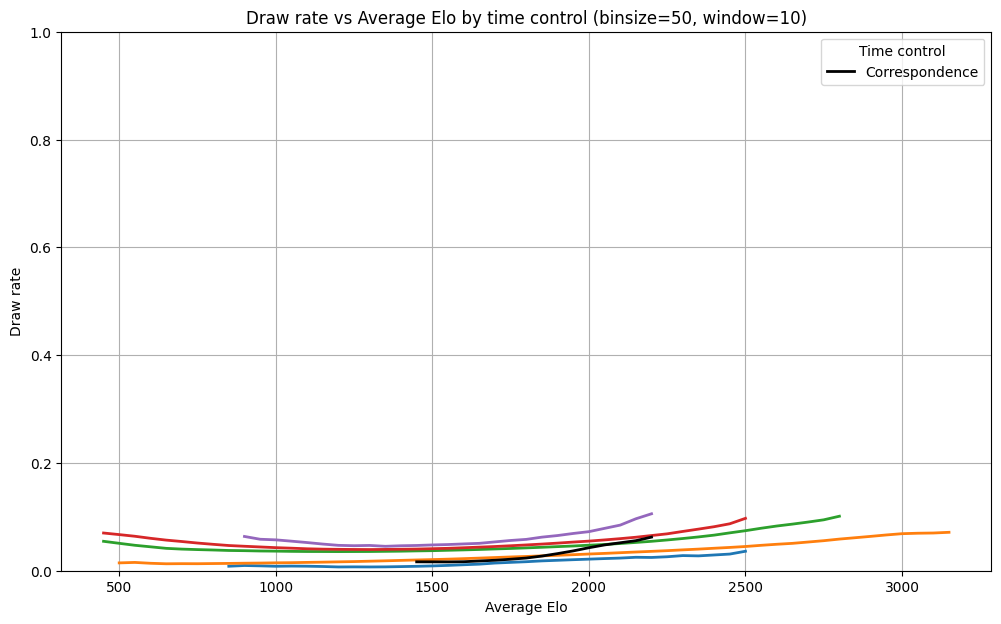

In [ ]:
plt.figure(figsize=(12,7))

colors = {
    "UltraBullet":"#1f77b4",
    "Bullet":"#ff7f0e",
    "Blitz":"#2ca02c",
    "Rapid":"#d62728",
    "Classical":"#9467bd",
}

for tc in time_controls:
    if tc != "Correspondence":
        g = df_smoothed[df_smoothed['time_control'] == tc].sort_values('elo_bin')
        if g.empty:
            continue

        # mask (exclude) bins with too few games
        g_plot = g[g['total_games'] >= min_games_per_bin]

        if g_plot.empty:
            # nothing to plot for this TC (all bins too small) -> skip plotting entirely
            continue

        # plot the (masked) smoothed line
        h, = plt.plot(
            g_plot['elo_bin'],
            g_plot['draw_rate_smooth'],
            label=tc,
            linewidth=2,
            color=colors.get(tc, 'k'),
            zorder=2
        )

        legend_handles = []
        legend_labels = []
        
        # record handle/label in order so legend respects this order
        legend_handles.append(h)
        legend_labels.append(tc)

# now create legend using the collected handles in that order
plt.legend(legend_handles, legend_labels, title='Time control', loc='best')

plt.xlabel('Average Elo')
plt.ylabel('Draw rate')
plt.title(f'Draw rate vs Average Elo by time control (binsize={binsize}, window={rolling_bins})')
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [382]:
# con.close()